In [12]:
import eda_helpers as eda

DATASET: https://huggingface.co/datasets/flwrlabs/pacs

```
@misc{li2017deeperbroaderartierdomain,
      title={Deeper, Broader and Artier Domain Generalization}, 
      author={Da Li and Yongxin Yang and Yi-Zhe Song and Timothy M. Hospedales},
      year={2017},
      eprint={1710.03077},
      archivePrefix={arXiv},
      primaryClass={cs.CV},
      url={https://arxiv.org/abs/1710.03077}, 
}
```

In [3]:
# Variables
DATASET_PATH = 'flwrlabs/pacs'
LABELS = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']

In [ ]:
data = eda.download_dataset(DATASET_PATH)
data['image'] = data.train.apply(lambda x: x['image'])
data['domain'] = data.train.apply(lambda x: x['domain'])
data['label'] = data.train.apply(lambda x: x['label'])
data = data.drop(columns='train')
data.head()

image        domain  label
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...  art_painting      0
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...  art_painting      0
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...  art_painting      0
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...  art_painting      0
4  <PIL.JpegImagePlugin.JpegImageFile image mode=...  art_painting      0

In [5]:
data.isna().sum(axis=0)
# no misses

image     0
domain    0
label     0
dtype: int64

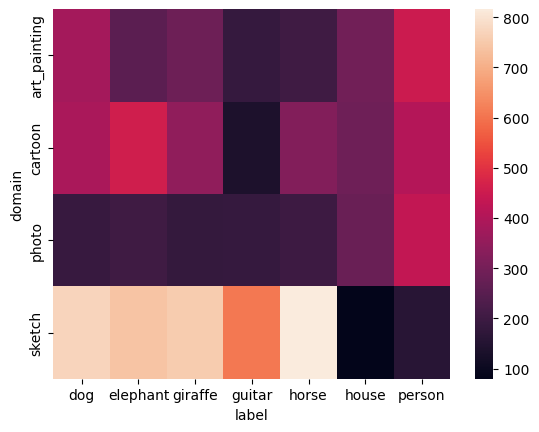

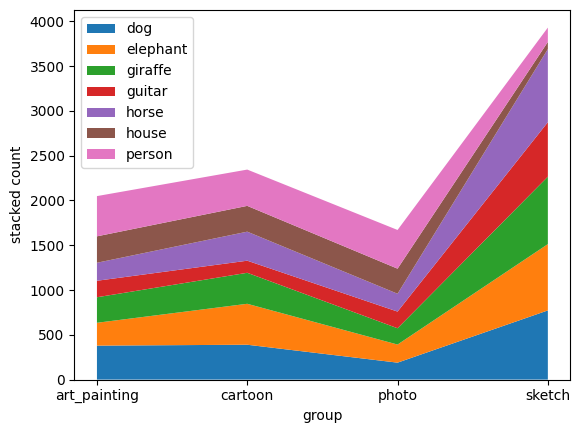

In [21]:
eda.twod_label_distribution(data, 'label', 'domain', LABELS)

Фотографий первых пяти категорий и скетчей последний двух - значитеьно мало. Больше всего скетчей первых пяти категорий.

У sketch сильный перекос между классами, photo суммарно уступает. guitar label довольно мало.

Cartoon и painting примерно одинаковы

In [23]:
DOMAIN = data.domain.unique()

In [24]:
data.image.apply(lambda x: x.size).unique()
# все фото одинакового размера


array([(227, 227)], dtype=object)

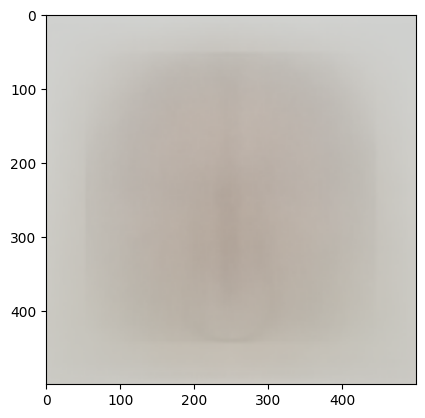

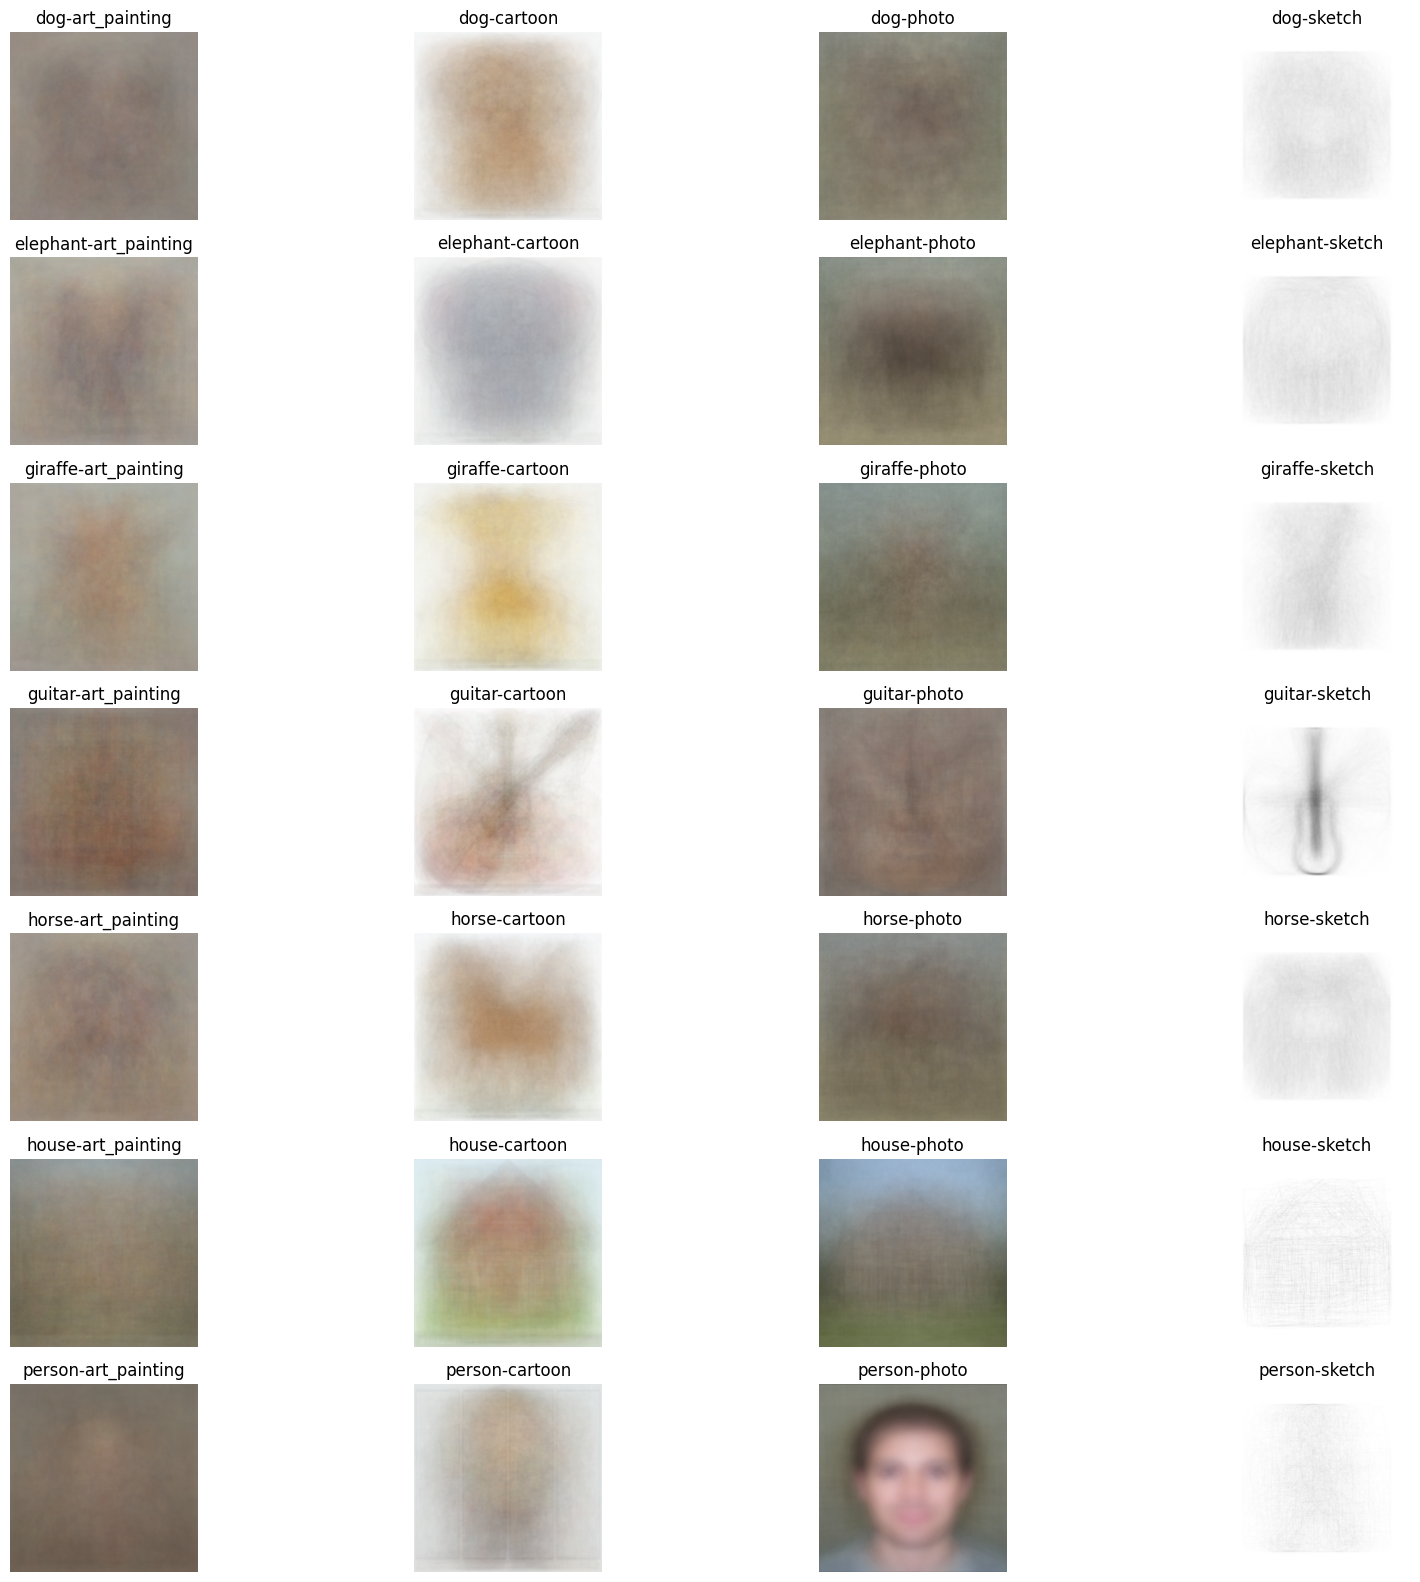

In [27]:
eda.draw_image_over_groups(data, lambda x: Image.fromarray(eda.find_mean_photo(x)).resize((500, 500)), DOMAIN, LABELS, 'domain', 'label', 'image')

Нормальные фото - dogs, elephants (не совсем понятно, мне кажется я могу там что-то различить) + все что не будет указано дальше
Есть проблема с одинаковыми фото (аугментация поможет где делают сдвиг и цветовое) - giraffe-cartoon, guitar-cartoon + guitar-sketch, horse-cartoon, house (all except for art-painting), 
Есть большие проблемы - face-photo.
В среднем изображении я немного вижу гитару, но помимо этого вроде норм.

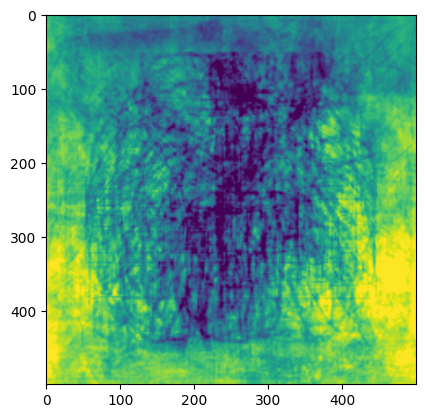

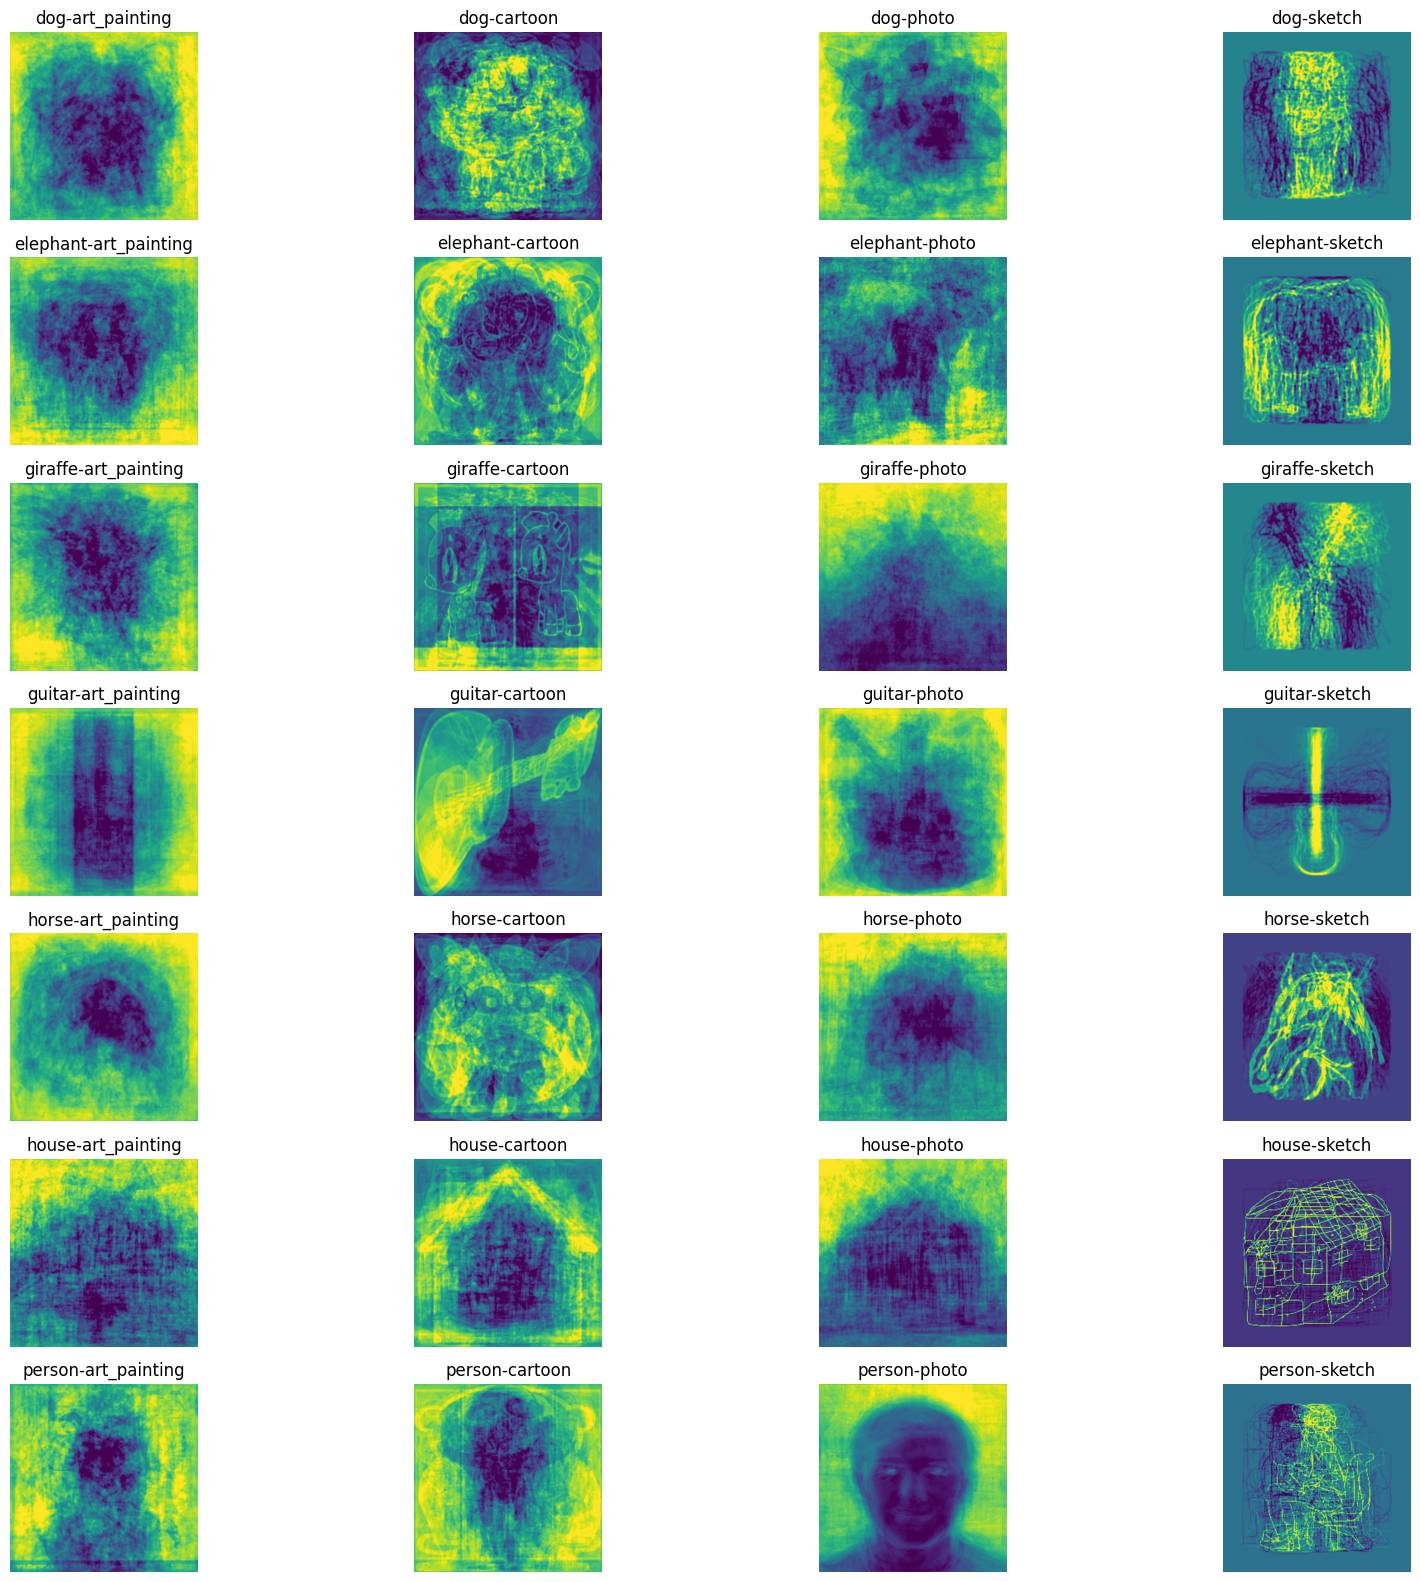

In [30]:
eda.draw_image_over_groups(data, lambda x: Image.fromarray(eda.find_eigenphoto(x)).resize((500, 500)), DOMAIN, LABELS, 'domain', 'label', 'image', random=True)

Хотя некоторые классы довольно выражены (фото человека - там скорее всего нет стоящих людей в полный рост, скетч дома - хотя он возможно компенсируется другими векторами), а скетч гитары можно определять довольно легко, большинство изображений не дают никакой информации, что происходит за ними, что говорит о довольно разнообразных классах (кроме перечисленных до этого).

In [35]:
# eda.see_samples(data, LABELS, DOMAIN, 1, 'image', 'domain', 'label')

Вроде рандомные семплы из изображений довольно разнородные. Дальше цвет

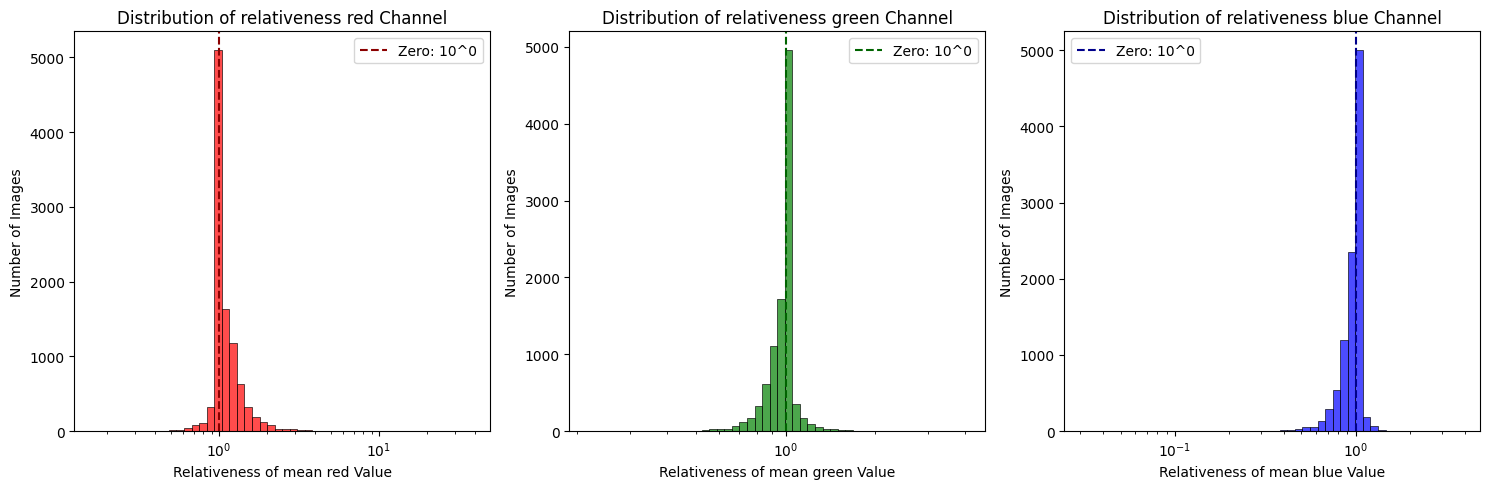

In [44]:
eda.draw_color_distrib(*eda.get_colors(eda.all_generator(data, 'image')))

В среднем по всем нет перекоса по цветам - все около 1

dog-art_painting


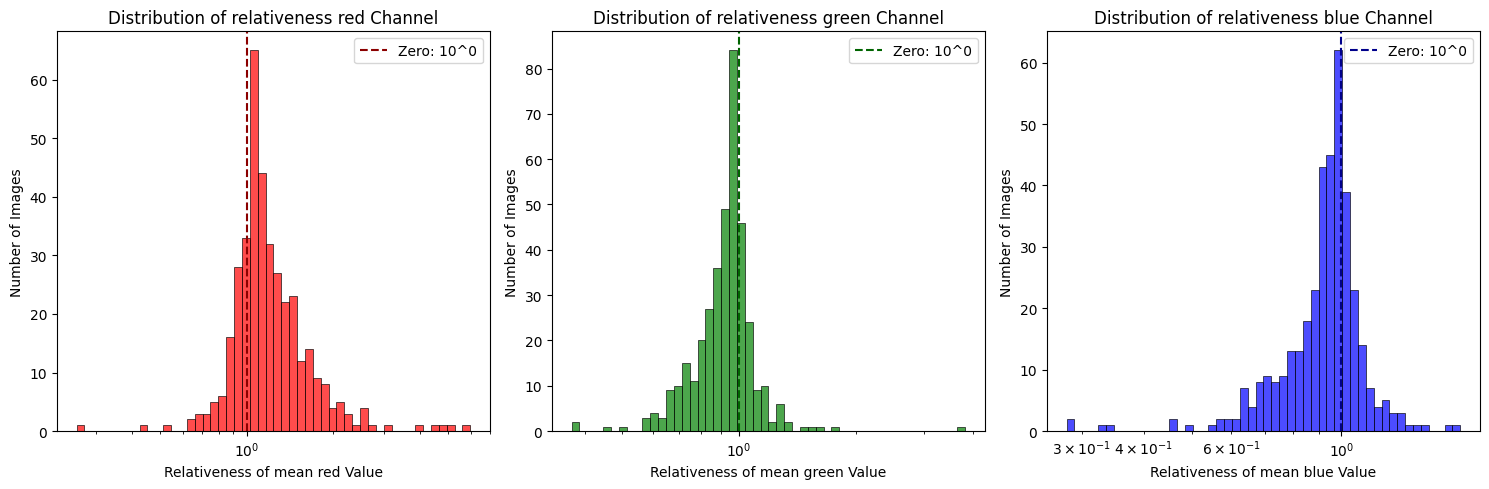

dog-cartoon


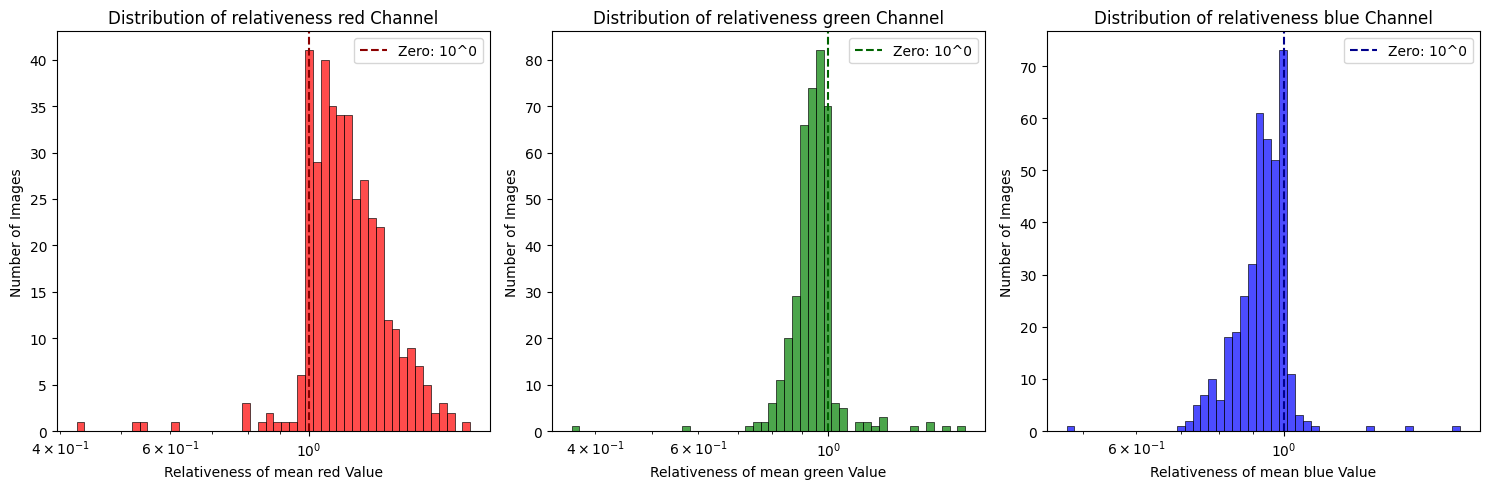

dog-photo


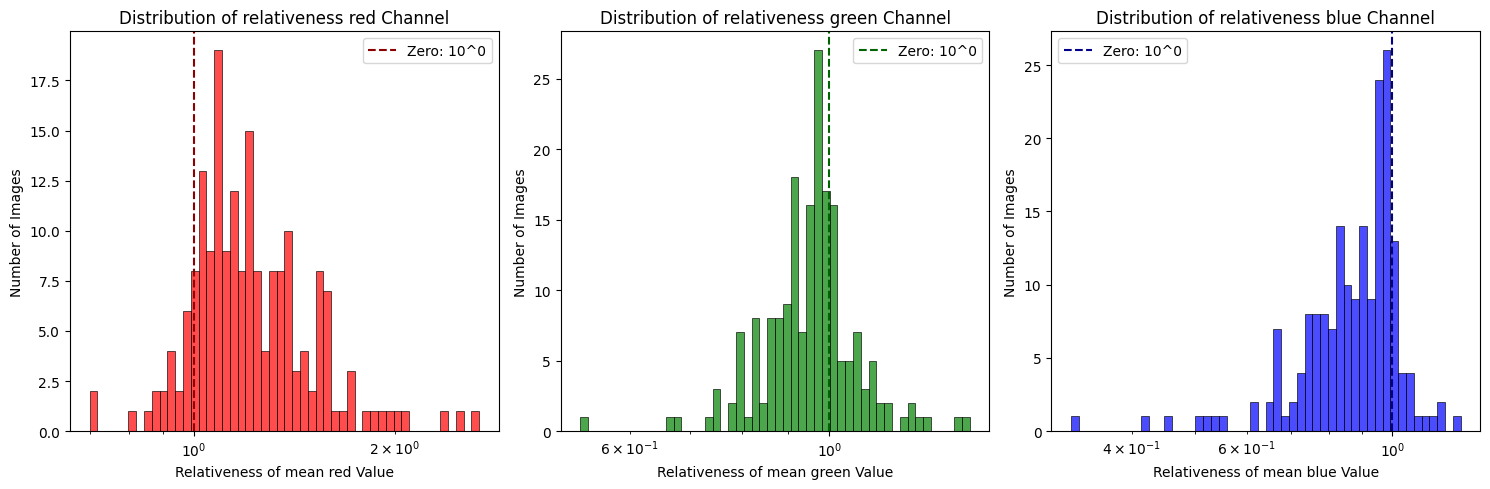

dog-sketch


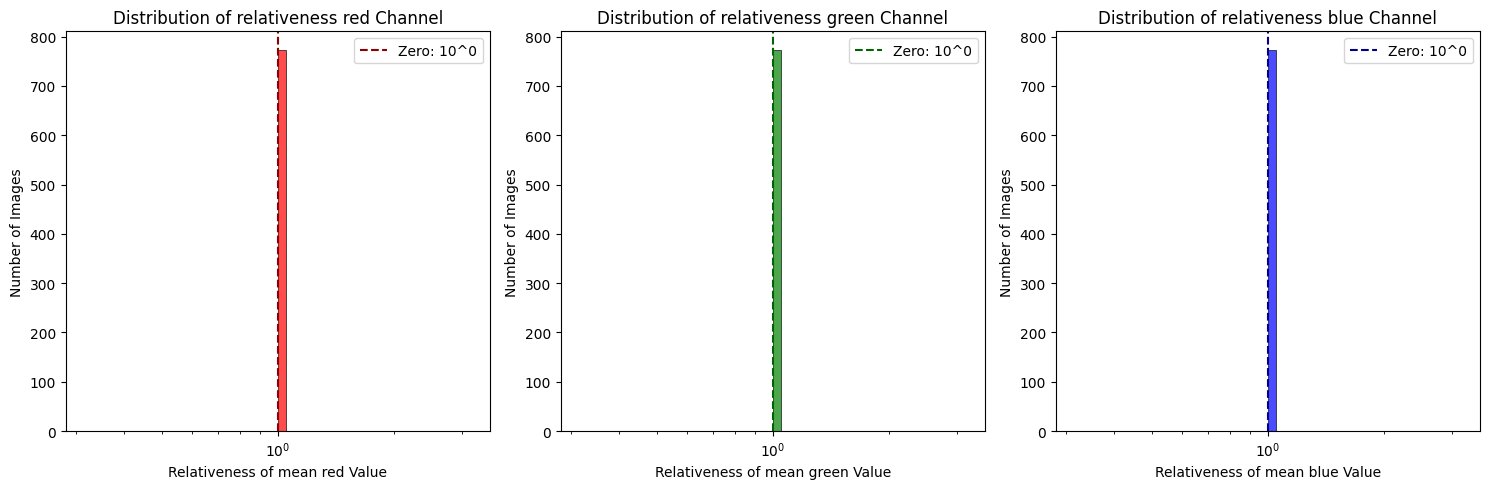

elephant-art_painting


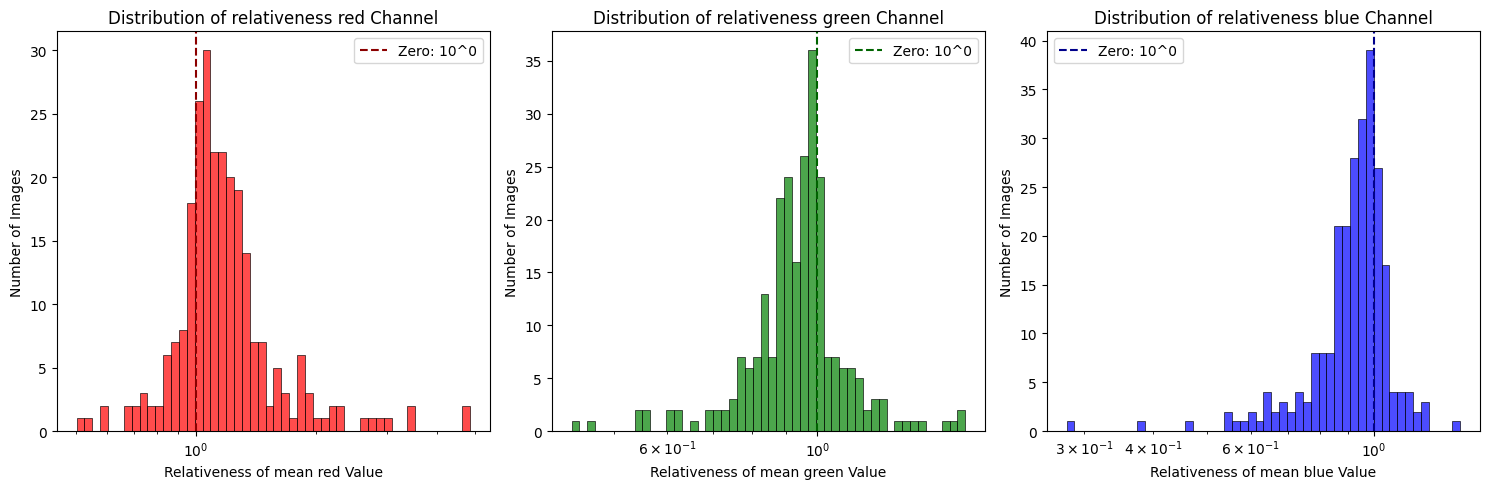

elephant-cartoon


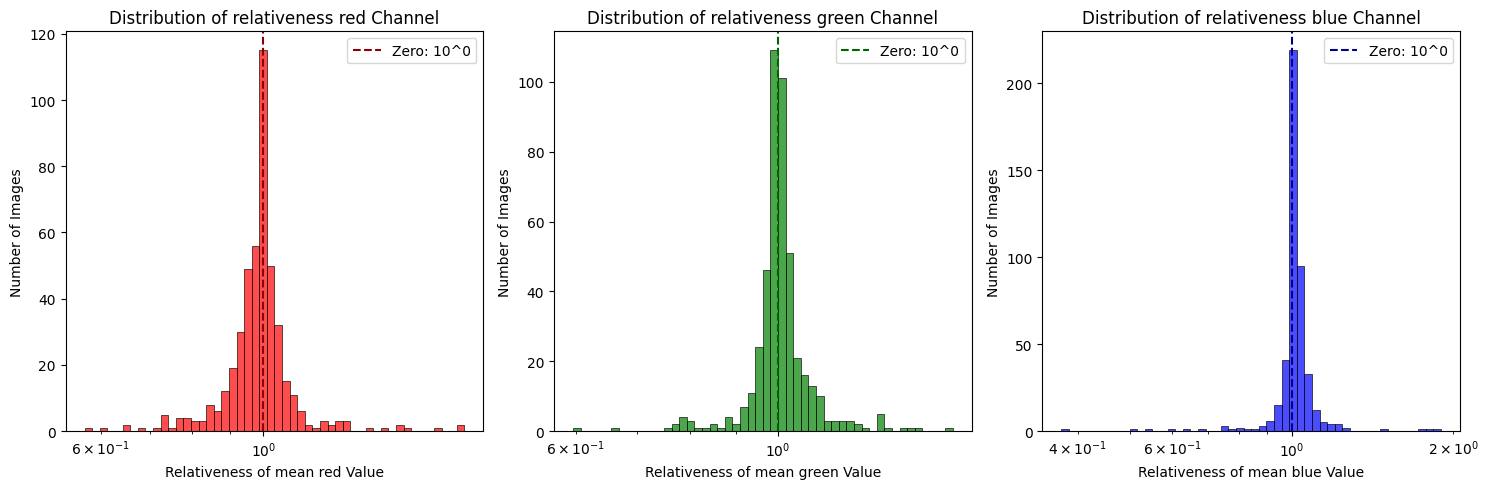

elephant-photo


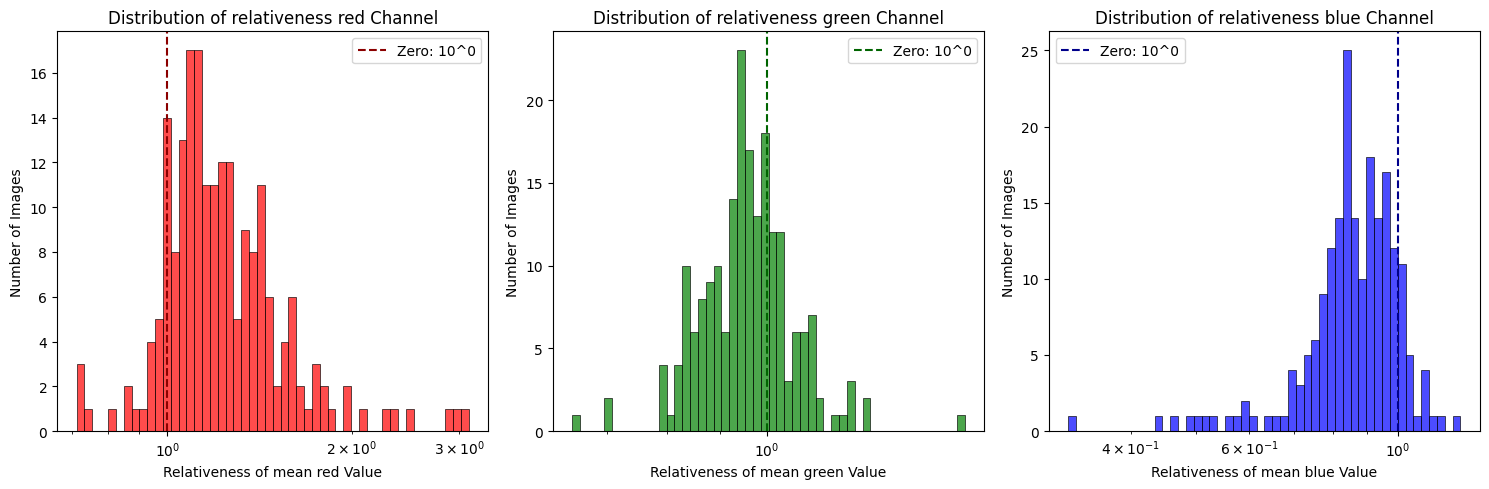

elephant-sketch


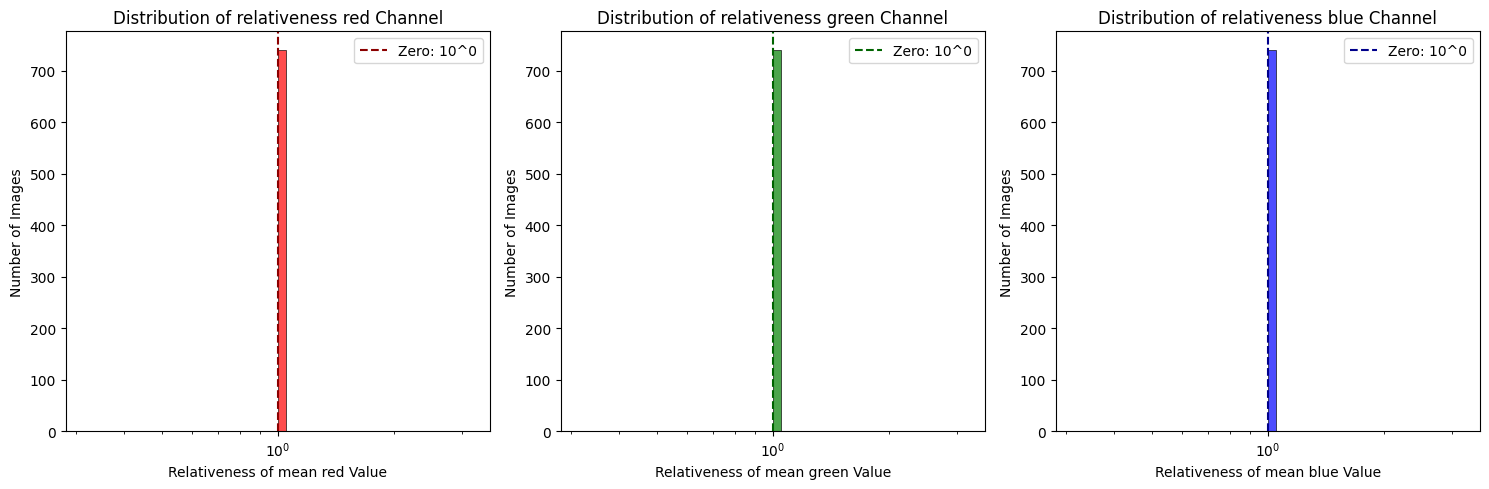

giraffe-art_painting


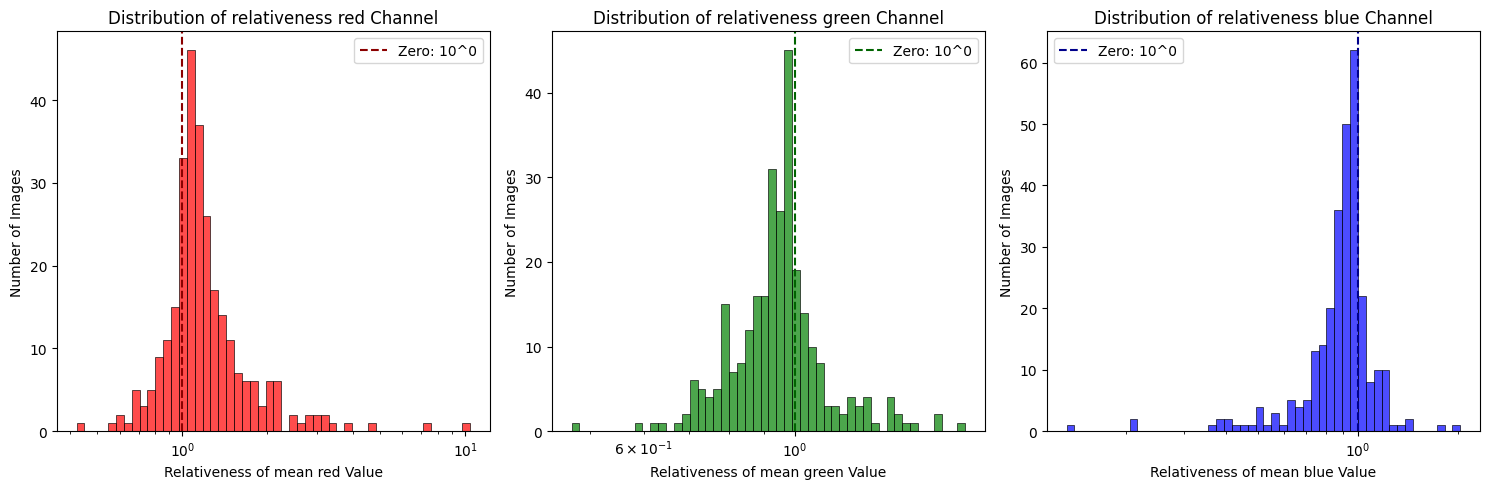

giraffe-cartoon


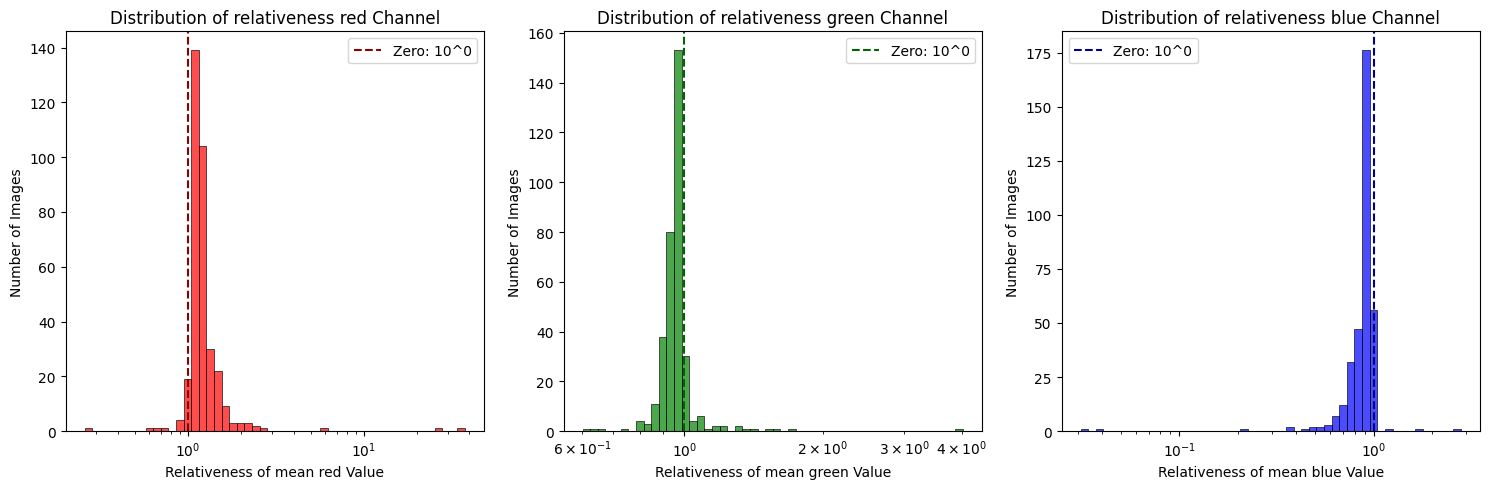

giraffe-photo


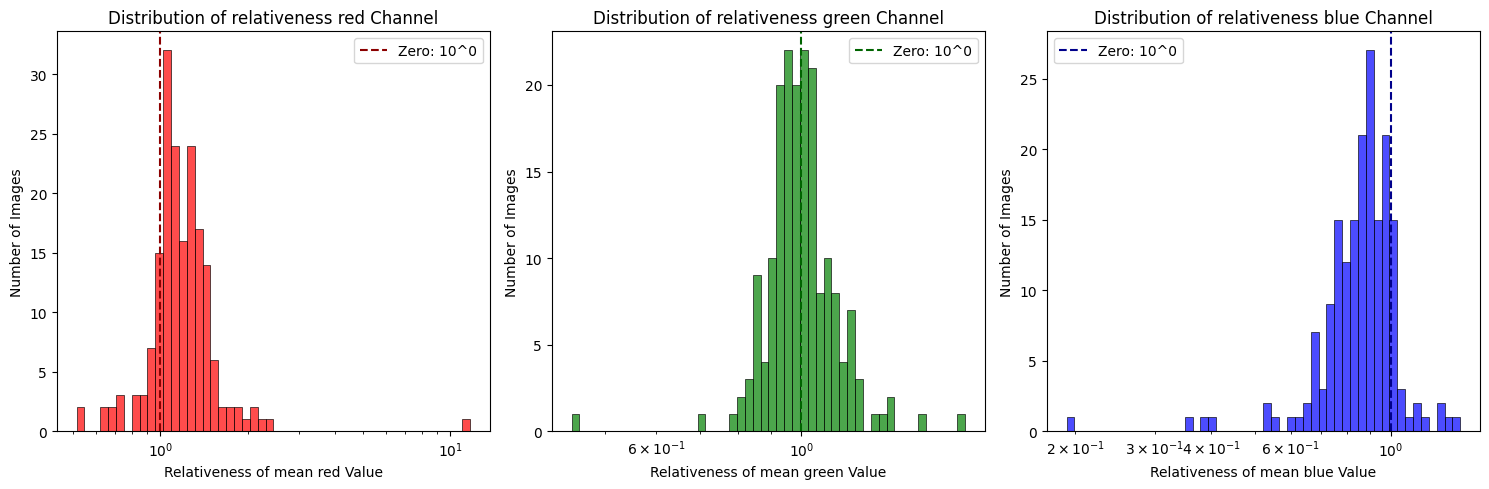

giraffe-sketch


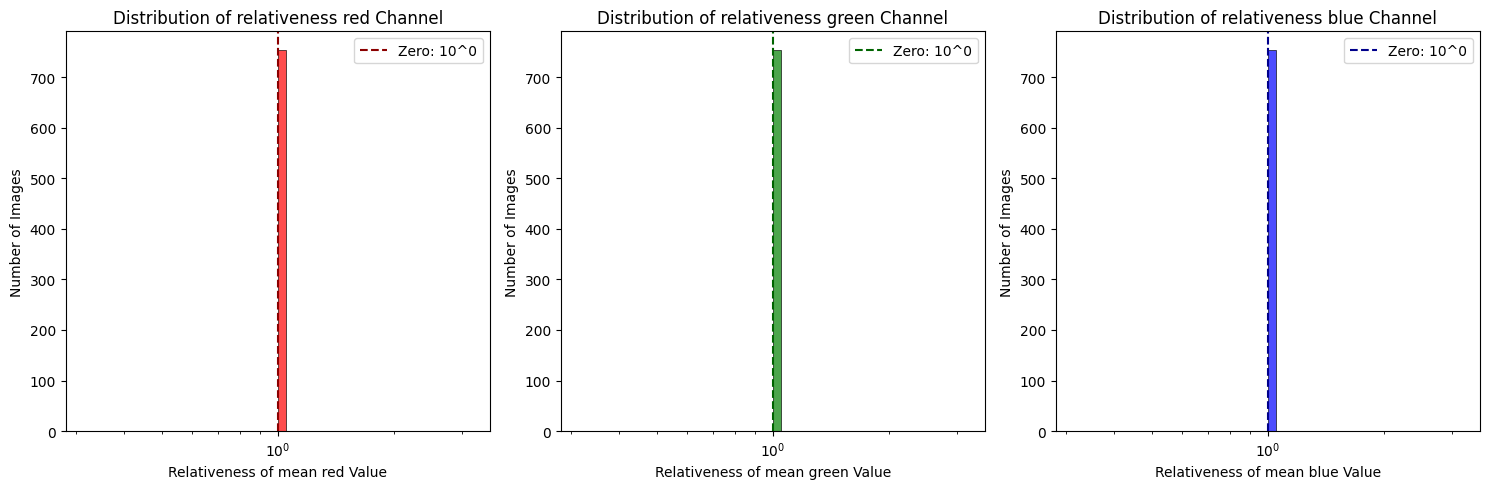

guitar-art_painting


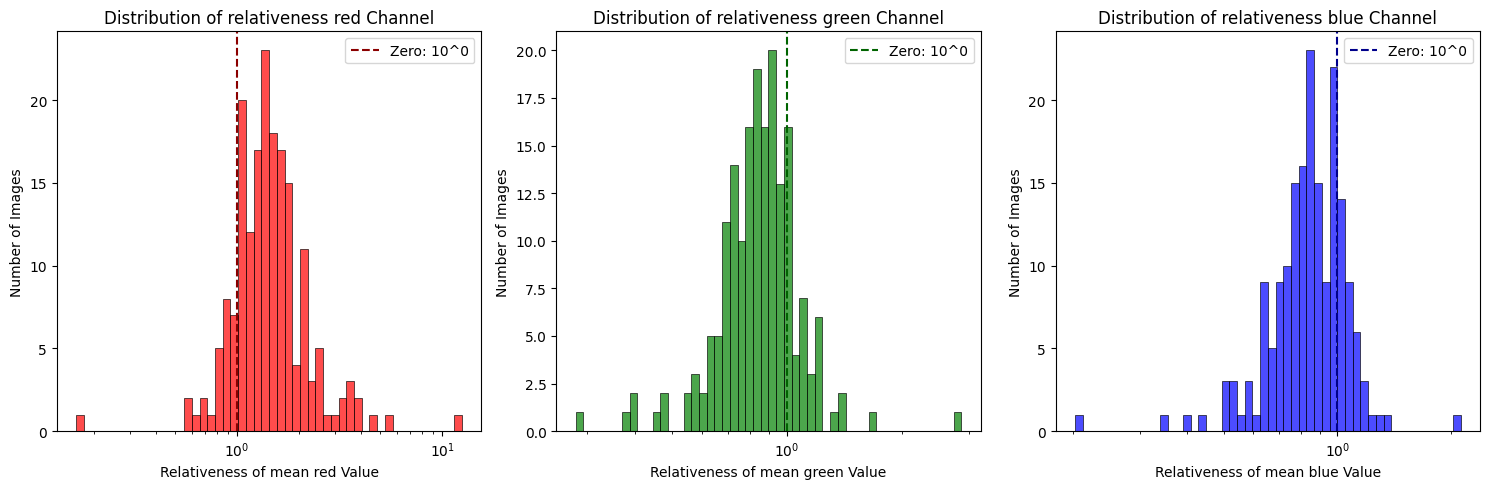

guitar-cartoon


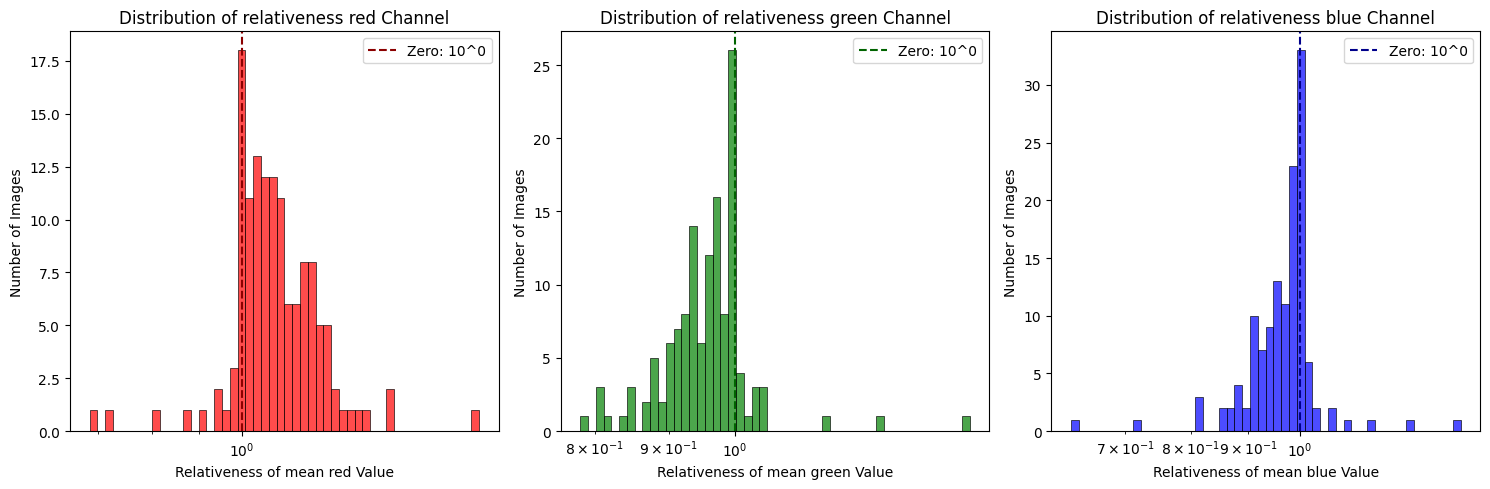

guitar-photo


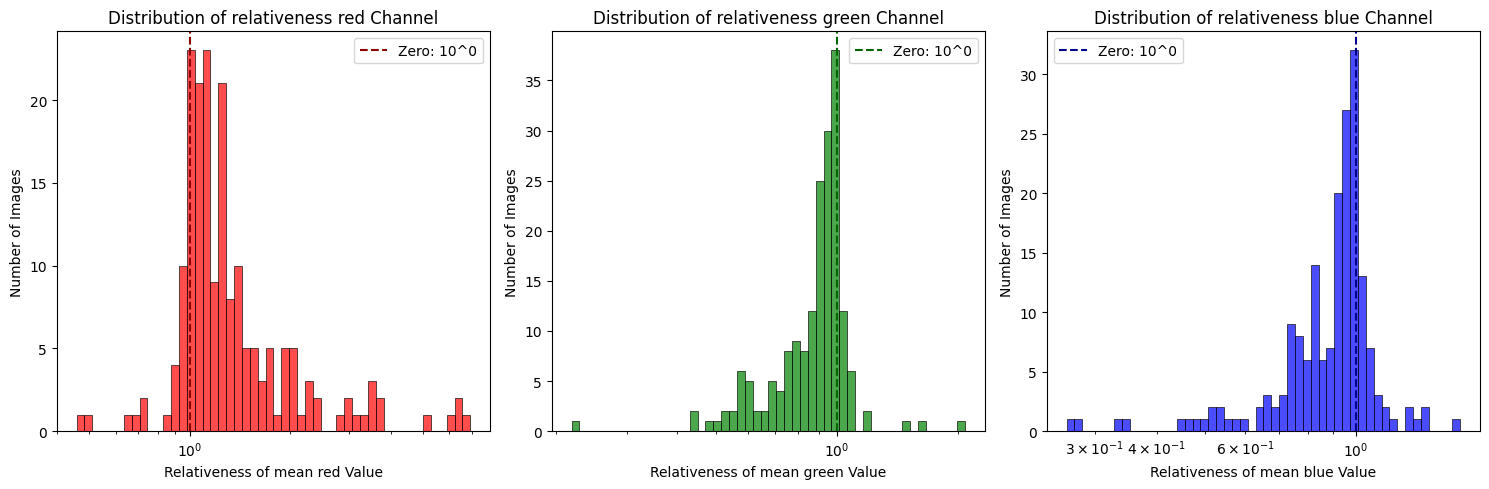

guitar-sketch


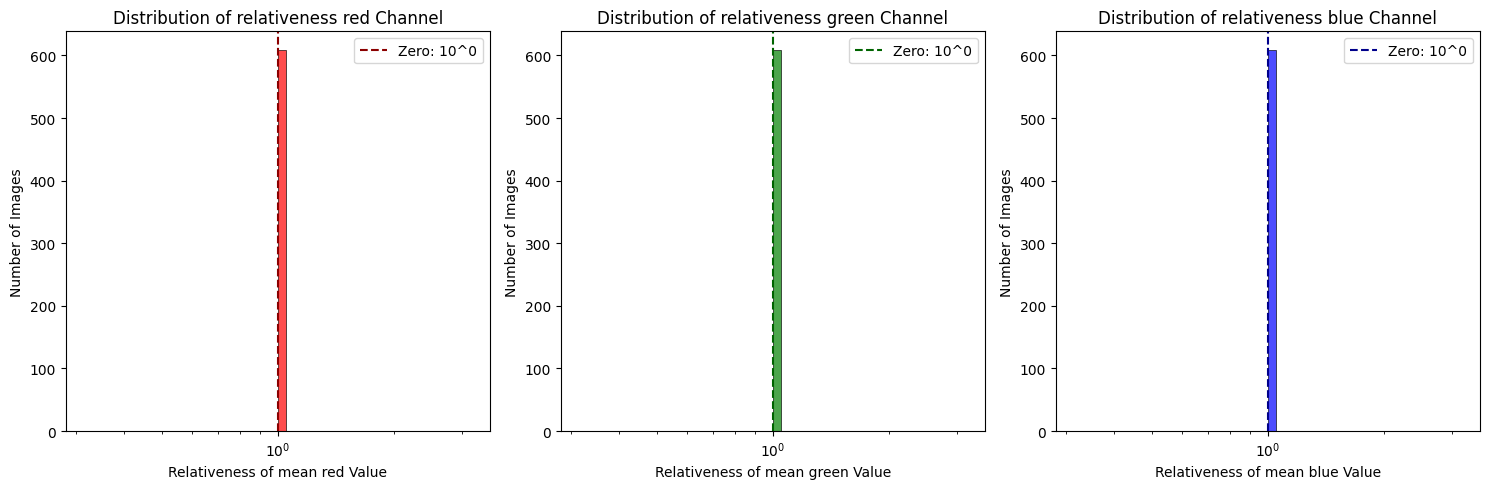

horse-art_painting


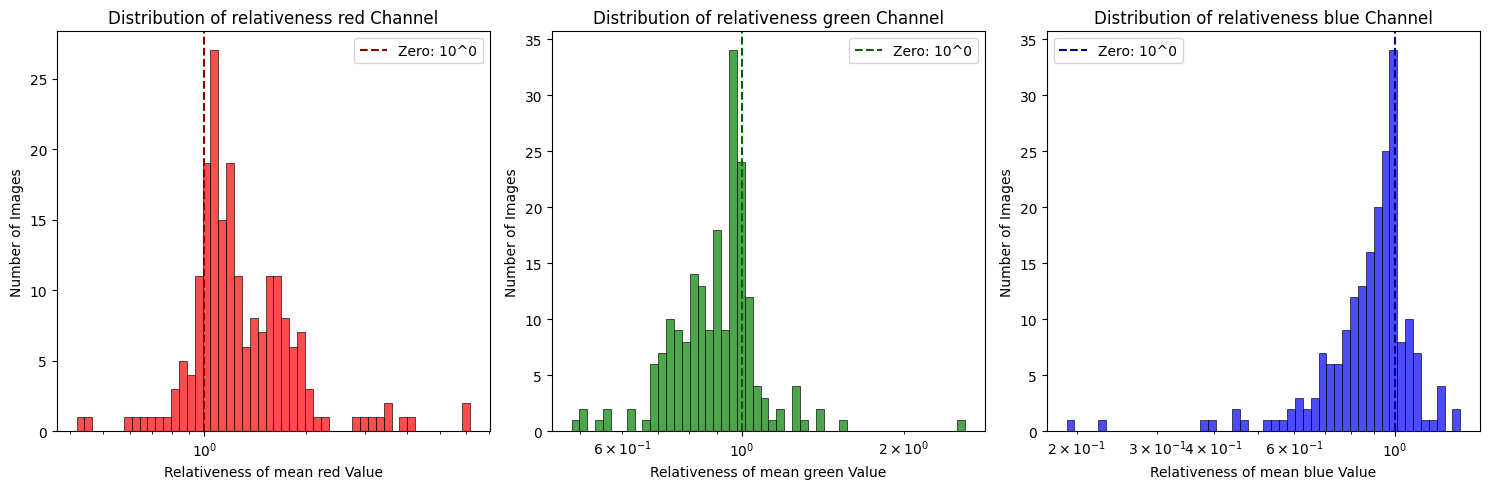

horse-cartoon


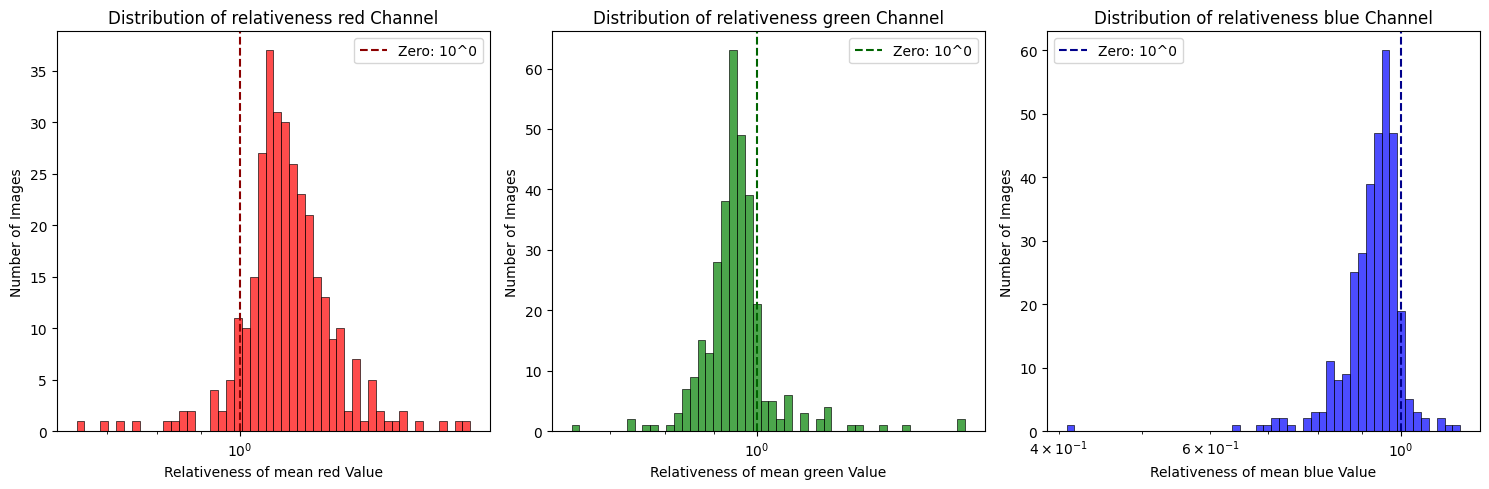

horse-photo


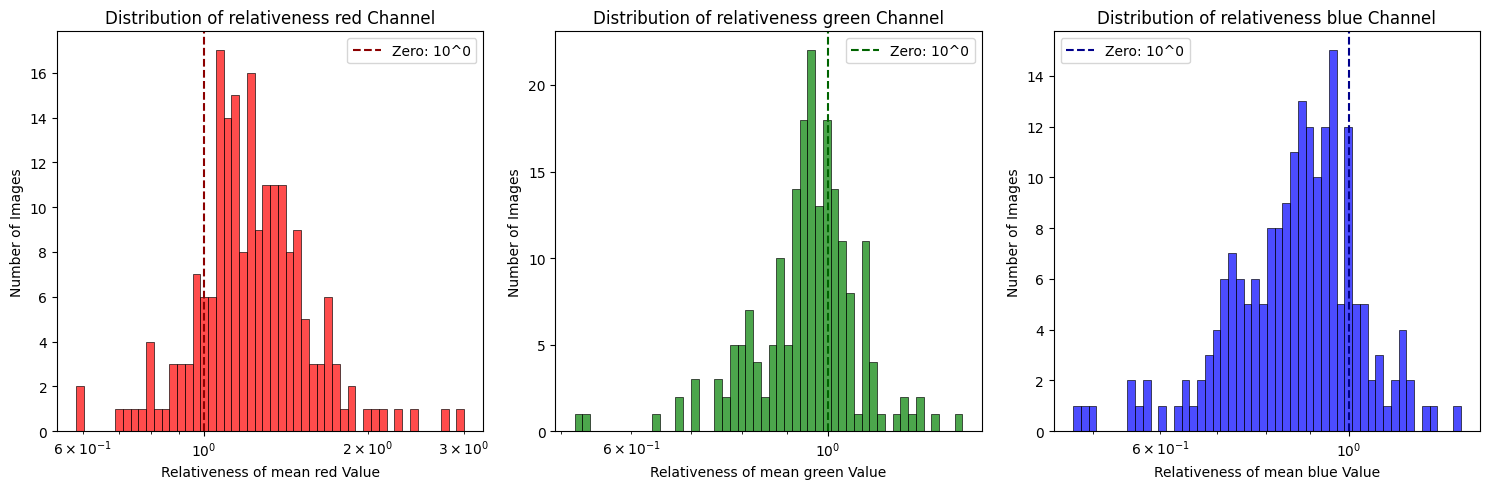

horse-sketch


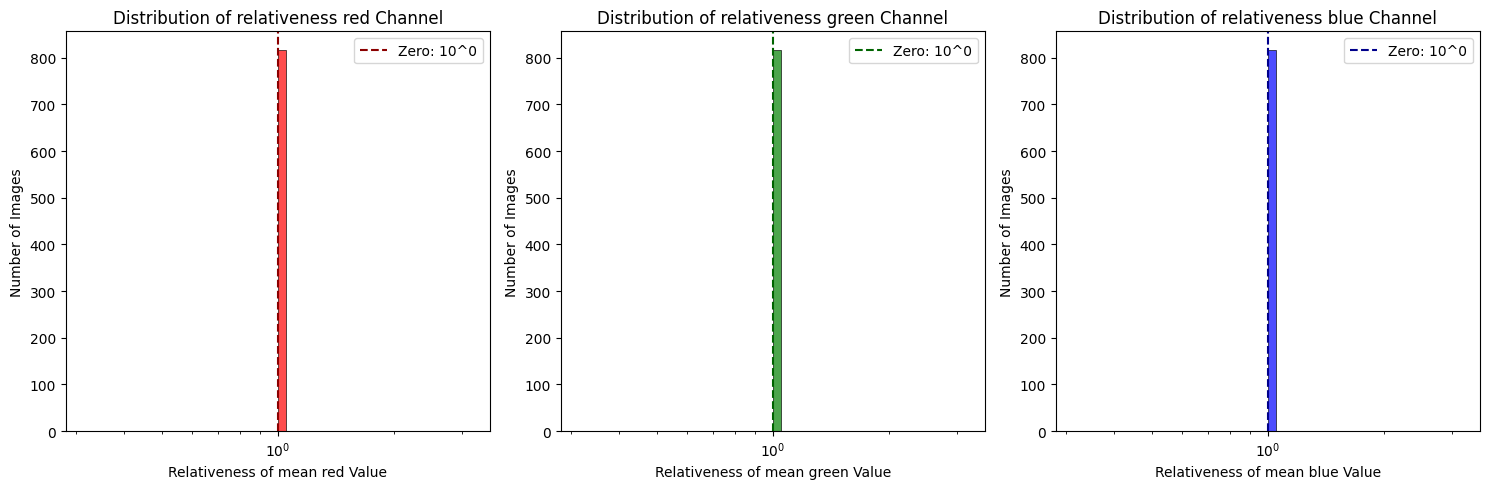

house-art_painting


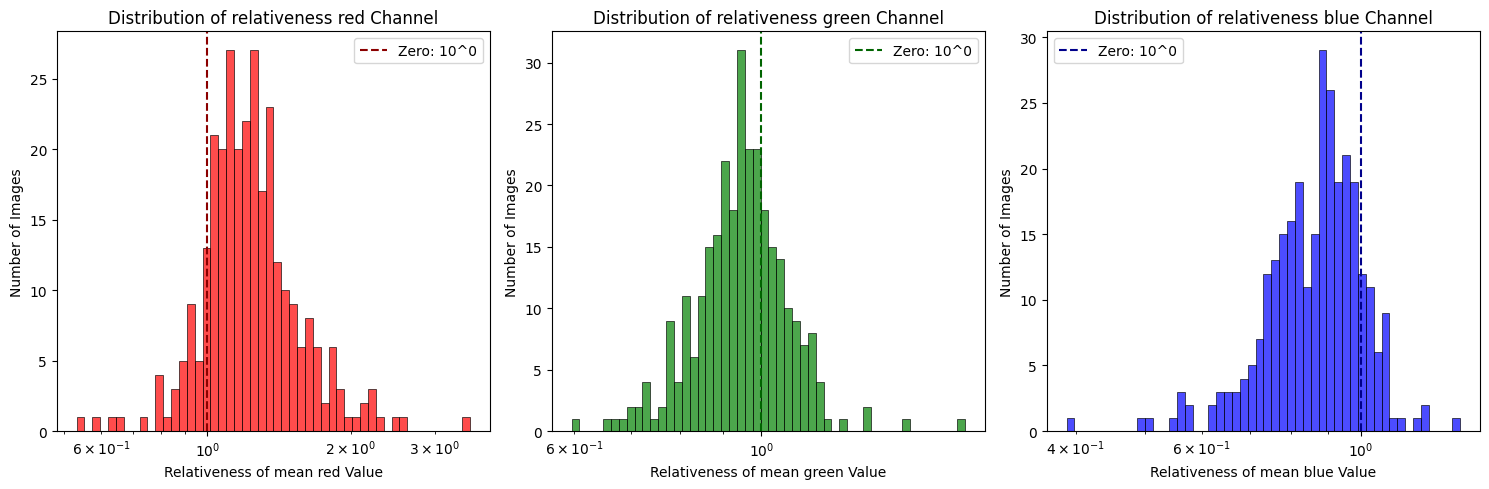

house-cartoon


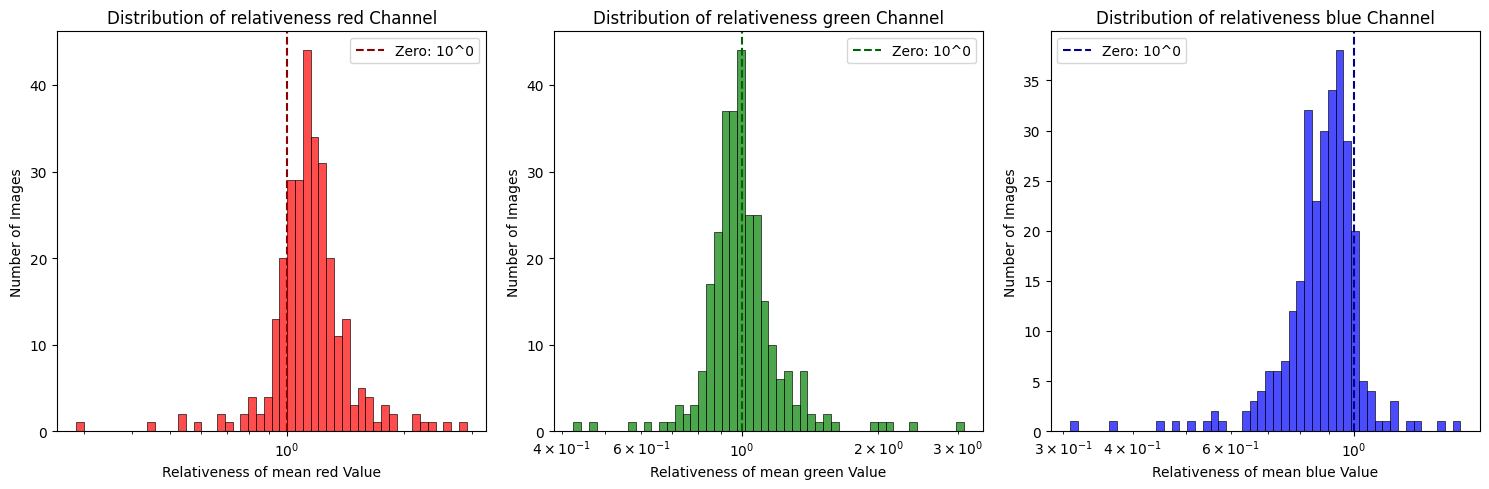

house-photo


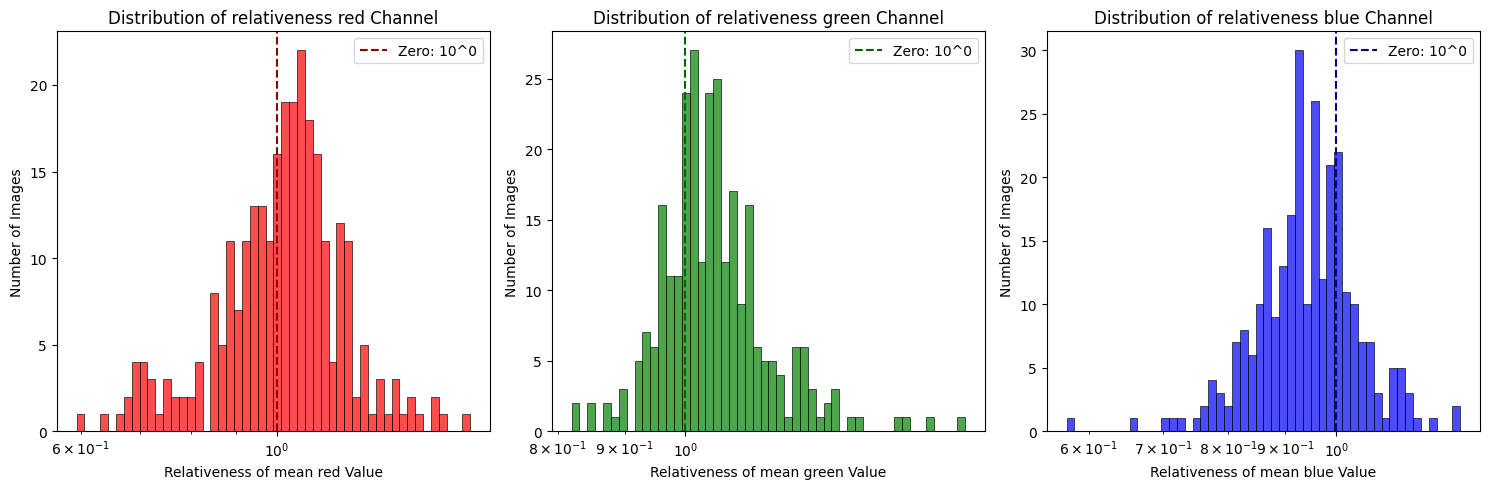

house-sketch


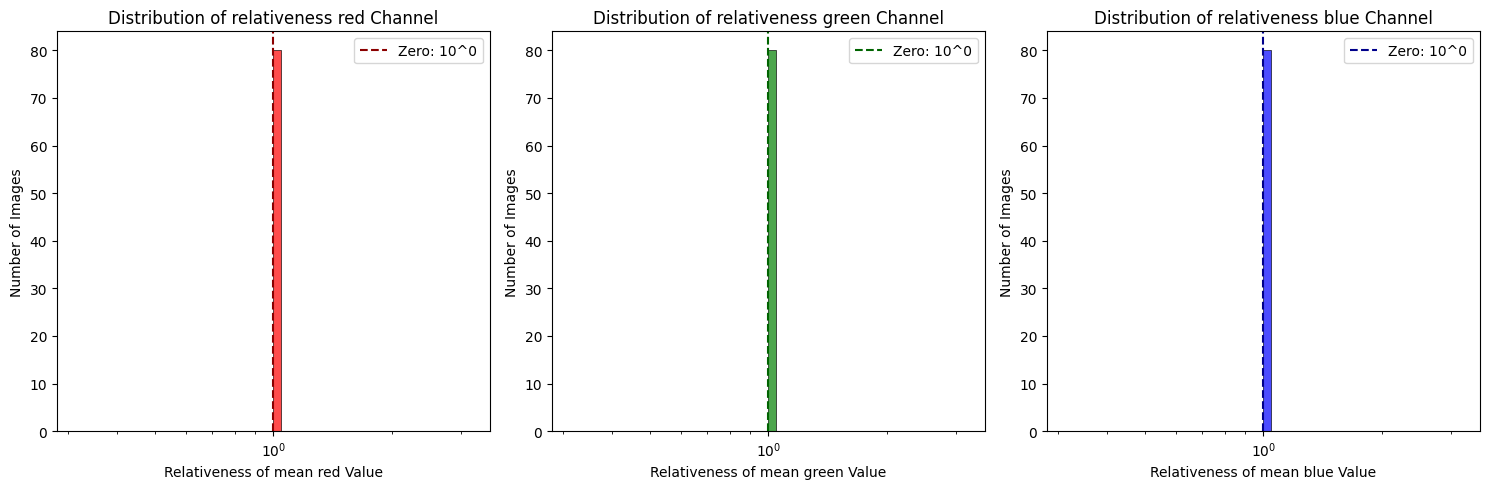

person-art_painting


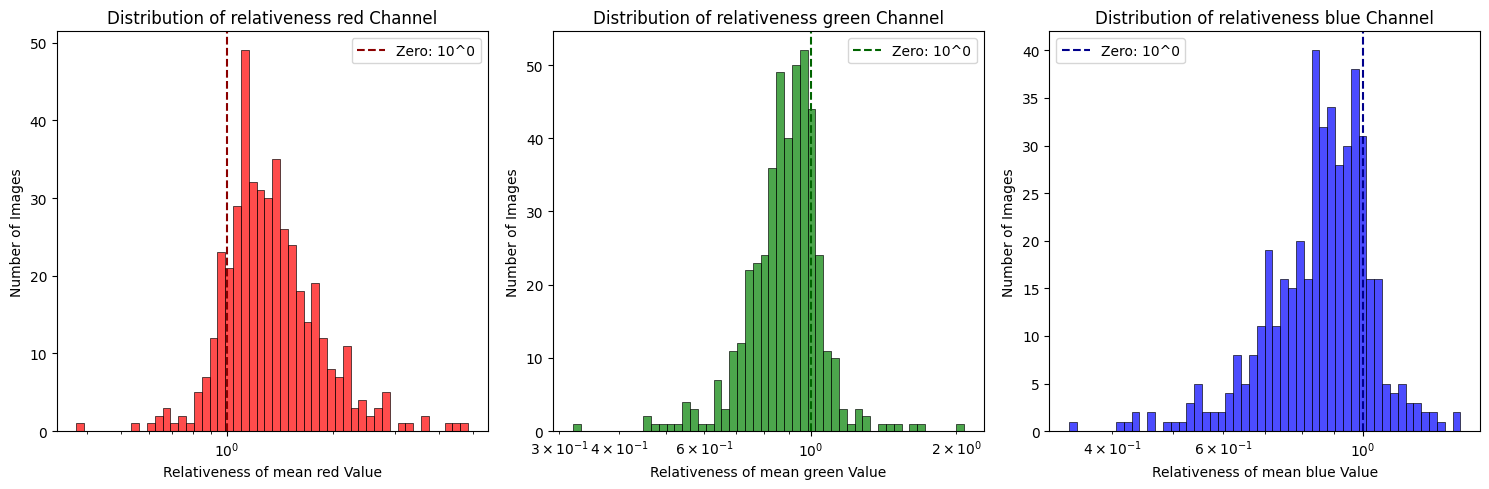

person-cartoon


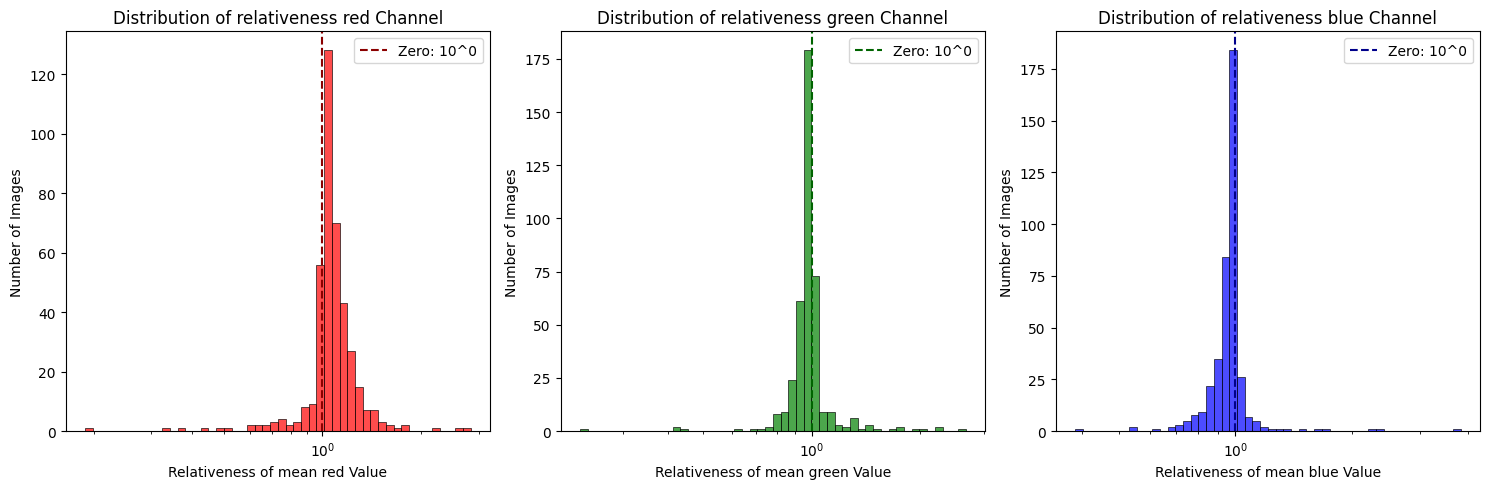

person-photo


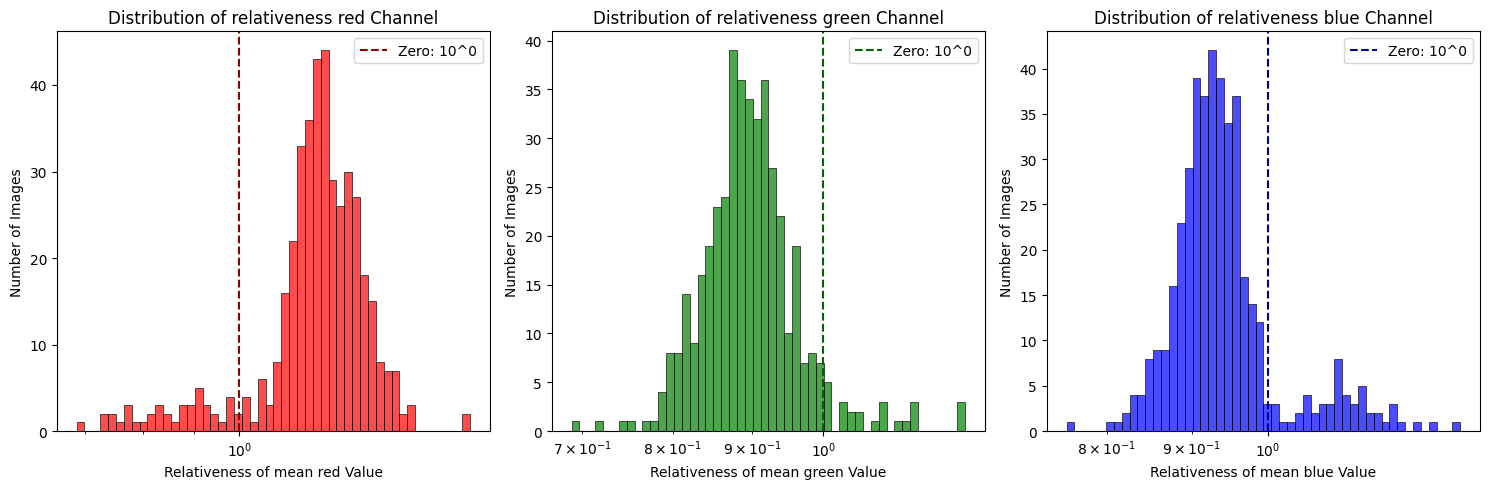

person-sketch


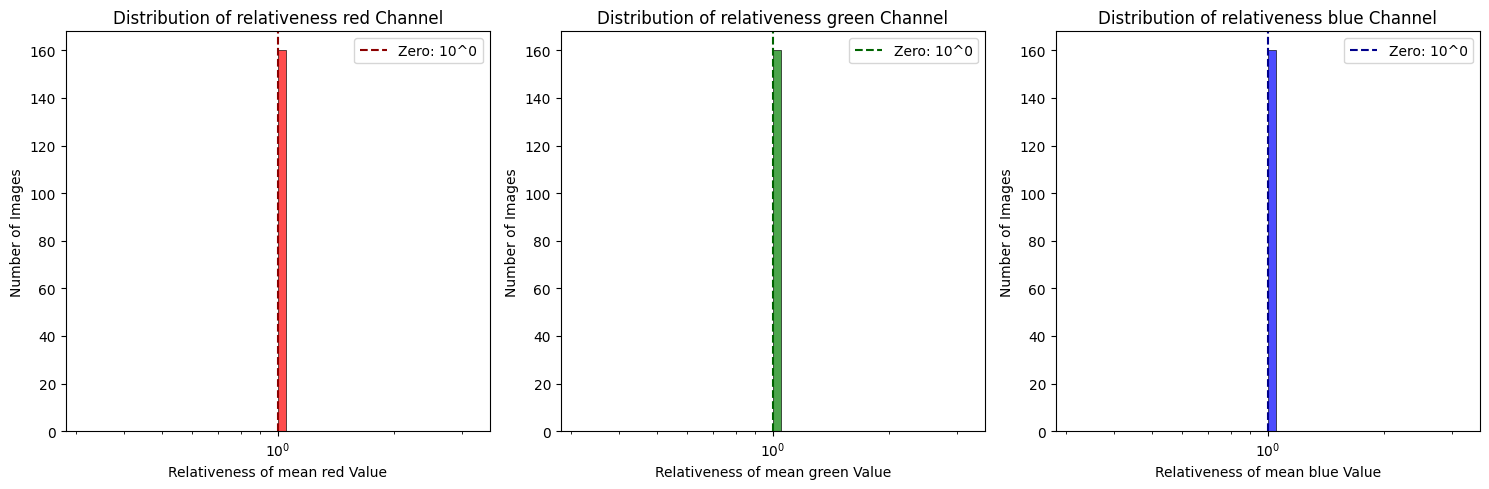

In [45]:
for label, label_name in enumerate(LABELS):
    for domain in data.domain.unique():
        print("{}-{}".format(label_name, domain))
        eda.draw_color_distrib(*eda.get_colors(eda.single_generator(data, 'image', 'domain', 'label', domain, label)))

elephant-photo (to red)

giraffe-photo (ro red slightly)

guitar-art_painting (to red)

horse-cartoon (to red)

horse-photo (To red)

house-art_painting (to red)

house-cartoon (to red against blue)

person-photo (to red a lot)

Как будто если ничего не сделать, то модель может научиться определять часть людей по цвету, как и понимать, что скетч - по одинаковым каналам. Но вроде для этого есть нормализатор (я что-то такое видела в процессинге модели)  

Кстати, скетчи довольно легко отличить по цветовой палитре. Нужно добавить им цвета будет

Можно посмотреть также на пару добученных моделей к датасету. Начнем с той, которая не роняет мой ноутбук (потом еще найду хост)

In [53]:
import psutil
import torch
device = torch.device('cpu')
torch.set_num_threads(psutil.cpu_count())

In [54]:
# Usage
model = eda.models.mobilenet_v3_small(pretrained=True)
model.classifier[3] = eda.nn.Linear(model.classifier[3].in_features, len(LABELS))

transform = eda.transforms.Compose([
        eda.transforms.Resize((64, 64)),  # Small images for CPU
        eda.transforms.ToTensor(),
        eda.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_loader, val_loader = eda.create_cpu_friendly_dataloaders(data, transform)
eda.cpu_friendly_train(device, model, train_loader, val_loader, epochs=10)

/home/ksenia/maga_code/cursach/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ksenia/maga_code/cursach/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
  Batch 0, Loss: 2.333, Acc: 0.00%
  Batch 10, Loss: 2.233, Acc: 13.64%
  Batch 20, Loss: 2.030, Acc: 20.83%
  Batch 30, Loss: 1.933, Acc: 25.20%
  Batch 40, Loss: 1.889, Acc: 26.07%
  Batch 50, Loss: 1.845, Acc: 28.68%
  Batch 60, Loss: 1.802, Acc: 30.43%
Epoch 1 Complete:
  Train Loss: 1.797, Train Acc: 31.10%
  Val Acc: 38.00%
--------------------------------------------------
Epoch 2/10
  Batch 0, Loss: 1.300, Acc: 62.50%
  Batch 10, Loss: 1.261, Acc: 56.25%
  Batch 20, Loss: 1.300, Acc: 54.17%
  Batch 30, Loss: 1.308, Acc: 53.23%
  Batch 40, Loss: 1.268, Acc: 54.57%
  Batch 50, Loss: 1.261, Acc: 55.15%
  Batch 60, Loss: 1.272, Acc: 53.89%
Epoch 2 Complete:
  Train Loss: 1.282, Train Acc: 53.80%
  Val Acc: 45.00%
--------------------------------------------------
Epoch 3/10
  Batch 0, Loss: 1.037, Acc: 62.50%
  Batch 10, Loss: 0.901, Acc: 68.75%
  Batch 20, Loss: 0.995, Acc: 63.69%
  Batch 30, Loss: 0.965, Acc: 65.12%
  Batch 40, Loss: 0.971, Acc: 64.94%
  Batch 50, Loss

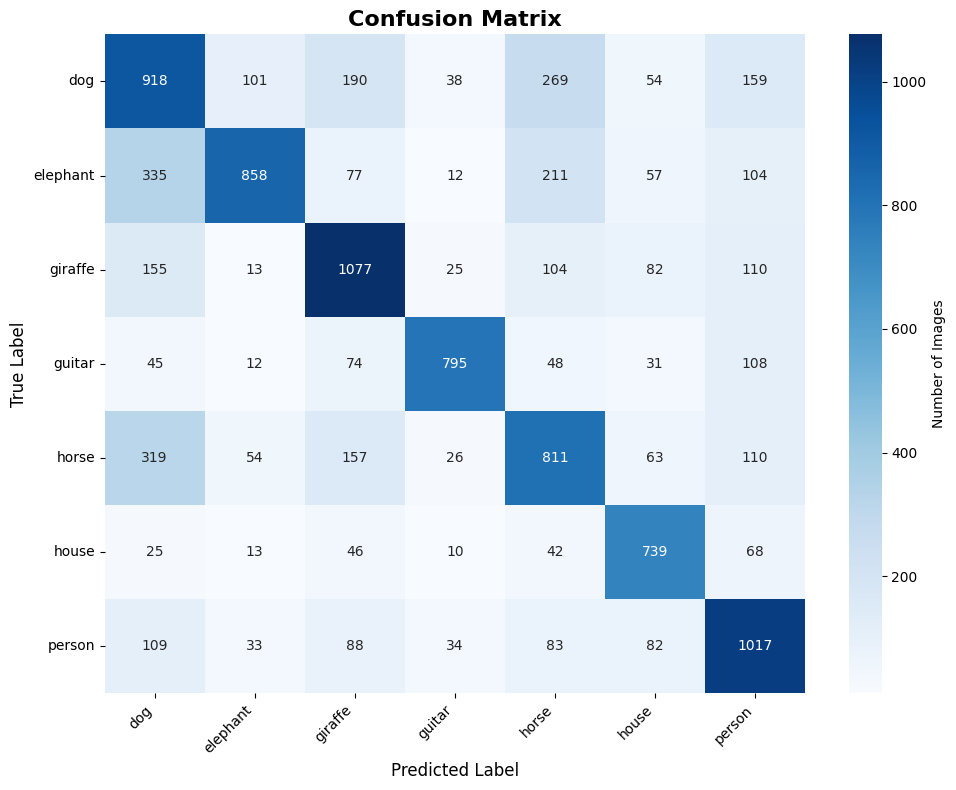

array([[ 918,  101,  190,   38,  269,   54,  159],
       [ 335,  858,   77,   12,  211,   57,  104],
       [ 155,   13, 1077,   25,  104,   82,  110],
       [  45,   12,   74,  795,   48,   31,  108],
       [ 319,   54,  157,   26,  811,   63,  110],
       [  25,   13,   46,   10,   42,  739,   68],
       [ 109,   33,   88,   34,   83,   82, 1017]])

art_painting:


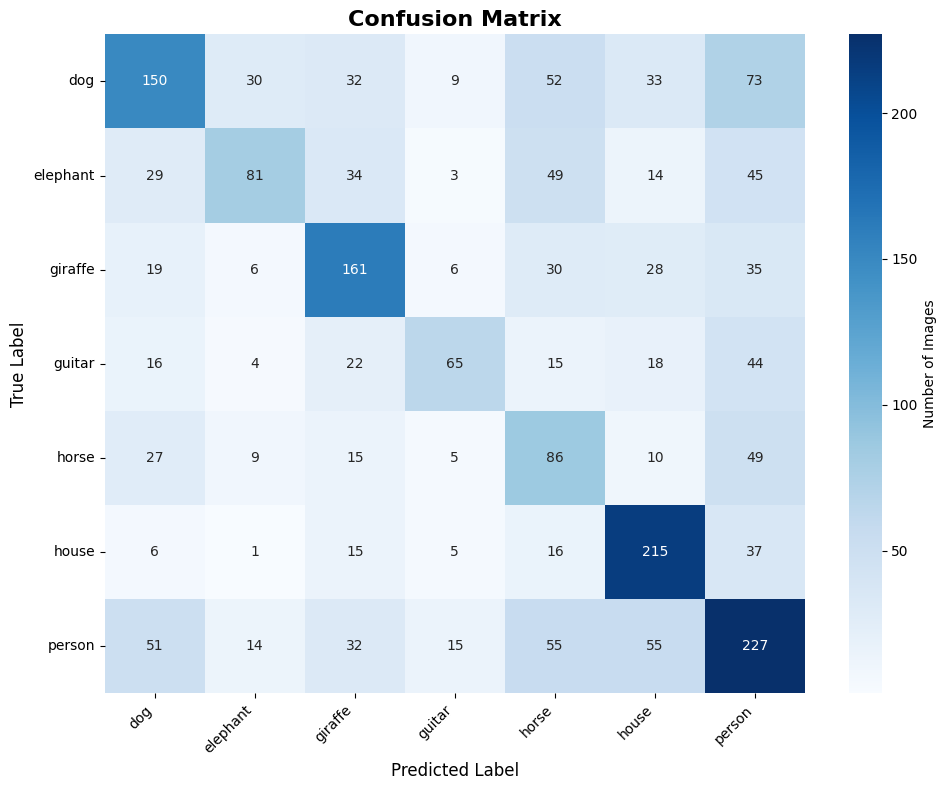

array([[150,  30,  32,   9,  52,  33,  73],
       [ 29,  81,  34,   3,  49,  14,  45],
       [ 19,   6, 161,   6,  30,  28,  35],
       [ 16,   4,  22,  65,  15,  18,  44],
       [ 27,   9,  15,   5,  86,  10,  49],
       [  6,   1,  15,   5,  16, 215,  37],
       [ 51,  14,  32,  15,  55,  55, 227]])

cartoon:


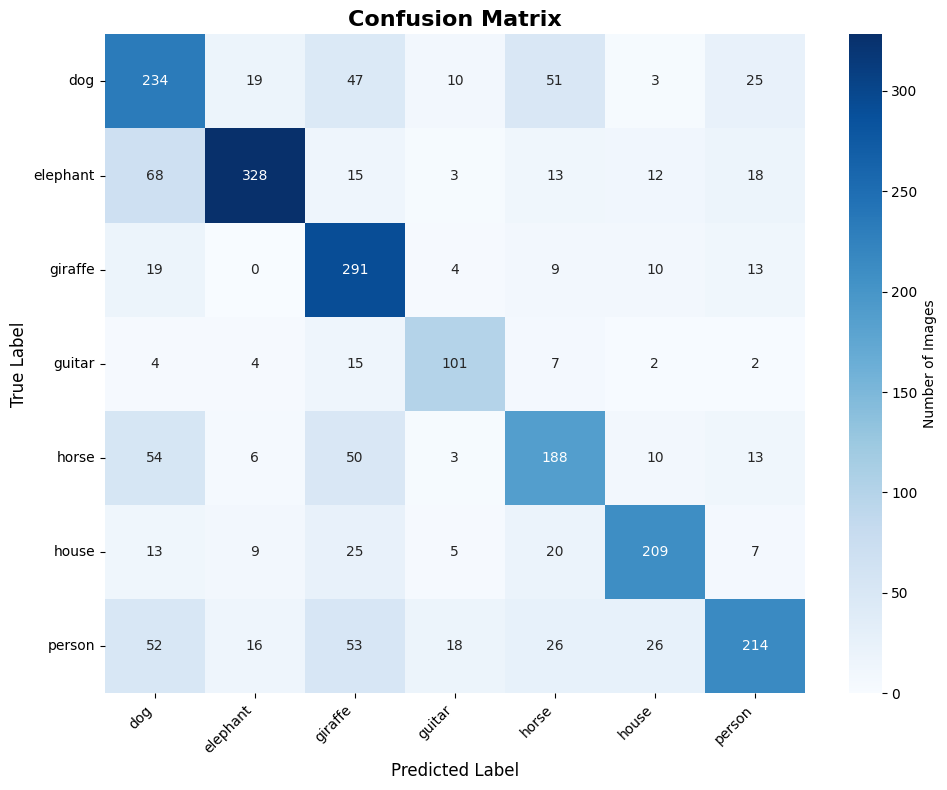

array([[234,  19,  47,  10,  51,   3,  25],
       [ 68, 328,  15,   3,  13,  12,  18],
       [ 19,   0, 291,   4,   9,  10,  13],
       [  4,   4,  15, 101,   7,   2,   2],
       [ 54,   6,  50,   3, 188,  10,  13],
       [ 13,   9,  25,   5,  20, 209,   7],
       [ 52,  16,  53,  18,  26,  26, 214]])

photo:


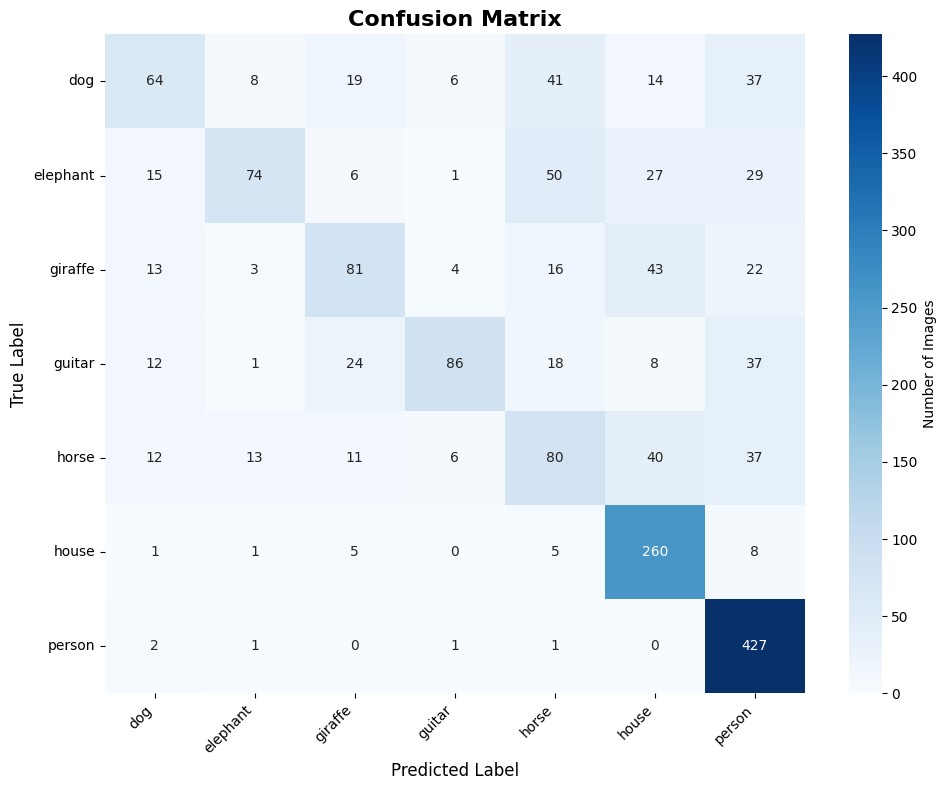

array([[ 64,   8,  19,   6,  41,  14,  37],
       [ 15,  74,   6,   1,  50,  27,  29],
       [ 13,   3,  81,   4,  16,  43,  22],
       [ 12,   1,  24,  86,  18,   8,  37],
       [ 12,  13,  11,   6,  80,  40,  37],
       [  1,   1,   5,   0,   5, 260,   8],
       [  2,   1,   0,   1,   1,   0, 427]])

sketch:


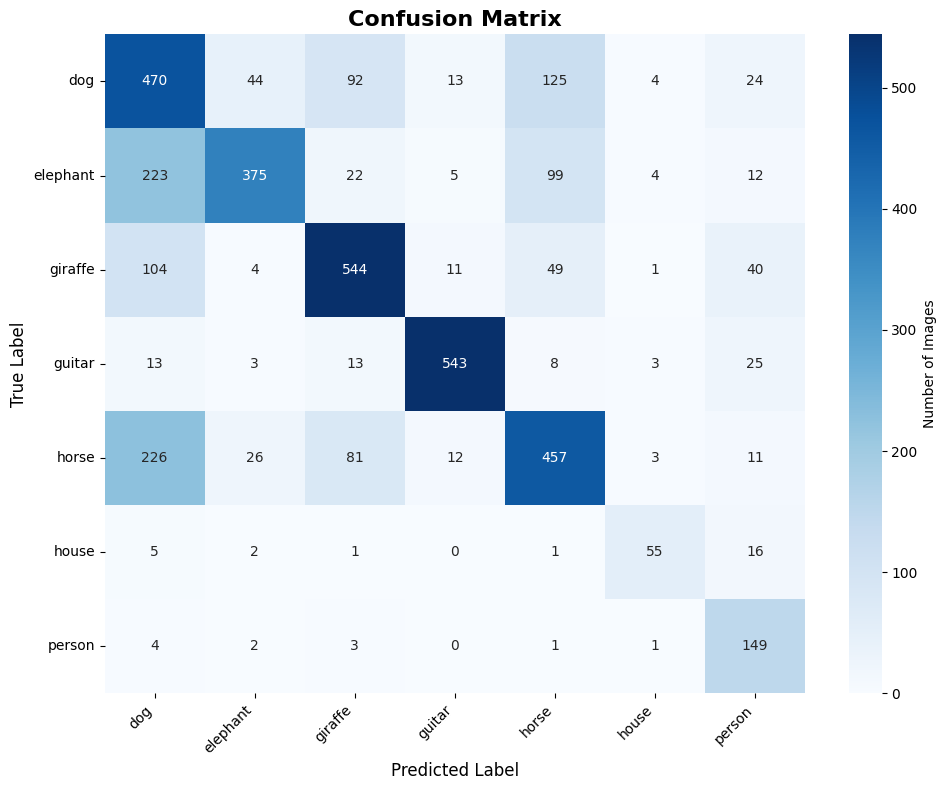

array([[470,  44,  92,  13, 125,   4,  24],
       [223, 375,  22,   5,  99,   4,  12],
       [104,   4, 544,  11,  49,   1,  40],
       [ 13,   3,  13, 543,   8,   3,  25],
       [226,  26,  81,  12, 457,   3,  11],
       [  5,   2,   1,   0,   1,  55,  16],
       [  4,   2,   3,   0,   1,   1, 149]])

In [59]:
val_dataset = eda.DataFrameImageDataset(data, "image", "label", transform)
val_loader = eda.DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=False)
predictions, targets, probabilities = eda.evaluate_model(model, val_loader, device)
cm = eda.plot_confusion_matrix(targets, predictions, LABELS)
display(cm)

for domain in DOMAIN:
    print(domain, end=':\n')
    val_dataset = eda.DataFrameImageDataset(data[data['domain'] == domain], "image", "label", transform)
    val_loader = eda.DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=False)
    
    
    predictions, targets, probabilities = eda.evaluate_model(model, val_loader, device)
    cm = eda.plot_confusion_matrix(targets, predictions, LABELS)
    display(cm)

In [1]:
# eda.visualize_errors(data, targets, predictions, probabilities, LABELS)

на маленьких моделях я смогла получить только 0.6 на eval выборке

In [ ]:
# import importlib

# importlib.reload(eda)


<module 'eda_helpers' from '/home/ksenia/maga_code/cursach/petrenko_third_attempt/EDA/eda_helpers.py'>